## Creating CNN-LSTM model 

In [1]:
from pymongo import MongoClient
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

In [2]:
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import LSTM , Dense , Flatten , Dropout , Input , Conv2D , MaxPooling2D , Dropout , TimeDistributed
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping

In [3]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix , accuracy_score

In [4]:
from Create_dataset import actions

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\python.exe
2.17.0
0.10.18


In [5]:
# File Path to store the landmark data

DATA_PATH = os.path.join("LANDMARK_DATA")

# Defining the actions 

actions = np.array(['hello' , 'thankyou' , 'iloveyou' , 'sorry' ,'A' , 'B' , 'C' , 'D' , 'E' , 'F'])
# Defining the number of videos per action

no_of_videos = 100

# Defining the number of frames per video

no_of_frames = 30

In [6]:
# actions = np.array(['hello' , 'thankyou' ,'iloveyou'])

# Creating Label Map 

label_map = {label:num for num,label in enumerate(actions)}

In [7]:
label_map

{'hello': 0,
 'thankyou': 1,
 'iloveyou': 2,
 'sorry': 3,
 'A': 4,
 'B': 5,
 'C': 6,
 'D': 7,
 'E': 8,
 'F': 9}

In [8]:
tf.random.set_seed(17)
np.random.seed(17)
random.seed(17)

#### 1. Extracting Data from MongoDB

In [9]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Preprocessed_Landmark_Data']

In [10]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [11]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda landmarks : [np.array(x) if isinstance(x , list) else x for x in landmarks])

100%|██████████| 1600/1600 [00:11<00:00, 134.00it/s]


In [12]:
np.array(df['Landmarks'][0]).shape

(30, 1662)

In [13]:
df['Landmarks'][0][0][0]

0.5282081961631775

To feed it into Conv2D , we need input in the shape of (height , width , channel)

In [14]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda row : np.array(row).reshape(30 , 1662 , 1) )

100%|██████████| 1600/1600 [00:00<00:00, 3311.88it/s]


In [15]:
df["Landmarks"][0].shape

(30, 1662, 1)

In [16]:
df['Landmarks'][0][0][0]

array([0.5282082])

In [17]:
# Deducing X and y vaues to split

X = np.array(df['Landmarks'].tolist())

labels_list = (df['Labels'].tolist())

y = to_categorical(labels_list).astype(int)
 

In [18]:
labels_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [19]:
X.shape

(1600, 30, 1662, 1)

In [20]:
y.shape

(1600, 10)

#### 2. Performing Train-test split
- using 95-5  percent train-test split

In [21]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.05)

In [22]:
print("X-train shape:" , X_train.shape)
print("X-test shape:" , X_test.shape)
print("y-train shape:" , y_train.shape)
print("y-test shape:" , y_test.shape)

X-train shape: (1520, 30, 1662, 1)
X-test shape: (80, 30, 1662, 1)
y-train shape: (1520, 10)
y-test shape: (80, 10)


#### Creating CNN_LSTM Model Arhictecture

In [23]:
X_train.shape

(1520, 30, 1662, 1)

In [24]:
actions.shape[0]

10

In [25]:
def create_LRCN_model(): 

 """"
 This function will construct the required  LRCN model architecture. 

 Returns:
  model : Required LRCN model

 """

 # We will use a Sequential Model Architecture

 model = Sequential()

 # Defining the Model Architecture

 model.add(Input(shape=(30 , 1662,1)))

 #CNN Layer 1
 model.add((Conv2D(filters= 16 , kernel_size= (3,3) , padding='same' , activation='relu')))
 model.add((MaxPooling2D((2,2))))
 model.add((Dropout(0.25)))

  #CNN Layer 2
 model.add((Conv2D(filters= 32 , kernel_size= (3,3) , padding='same' , activation='relu')))
 model.add((MaxPooling2D((2,2))))
 model.add((Dropout(0.25)))

 #  #CNN Layer 3
 # model.add((Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # # model.add(TimeDistributed(MaxPooling2D((1,2))))
 # model.add((Dropout(0.25)))
 
   #CNN Layer 4
 model.add((Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 # model.add(TimeDistributed(Dropout(0.25)))

 model.add((TimeDistributed(Flatten())))

 # Feeding the extracted features to the LSTM layers

 model.add(LSTM(32))

 #Adding dese layer for classification 

 model.add(Dense(actions.shape[0] , activation='softmax' ))

 #Display model summary

 model.summary()

 #Return the constructed LRCN model

 return model

In [26]:
# construct the model

LRCN_model = create_LRCN_model()

print('Model Created Successfuly')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 1662, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 831, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 831, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 831, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 415, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 415, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 415, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 26560)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │     3,403,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,427,530 (13.07 MB)

 Trainable params: 3,427,530 (13.07 MB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfuly


In [27]:
LRCN_model.compile(optimizer= 'Adam' , loss = 'categorical_crossentropy' , metrics =['categorical_accuracy'])

In [28]:
LRCN_model_history = LRCN_model.fit(X_train , y_train , epochs= 100  , validation_split=0.2)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - categorical_accuracy: 0.2526 - loss: 2.1532 - val_categorical_accuracy: 0.2730 - val_loss: 2.0554
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 484ms/step - categorical_accuracy: 0.4353 - loss: 1.8027 - val_categorical_accuracy: 0.4934 - val_loss: 1.7154
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 483ms/step - categorical_accuracy: 0.5031 - loss: 1.5982 - val_categorical_accuracy: 0.4276 - val_loss: 1.6429
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 482ms/step - categorical_accuracy: 0.5380 - loss: 1.4578 - val_categorical_accuracy: 0.4572 - val_loss: 1.5594
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 507ms/step - categorical_accuracy: 0.5529 - loss: 1.3800 - val_categorical_accuracy: 0.5263 - val_loss: 1.5300
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - categorical_accuracy: 0.5614 - loss: 1.3532 - val_categorical_accuracy: 0.5592 - val_loss: 1.4898
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 482ms/step - categorical_accuracy

#### Analyzing Training Results

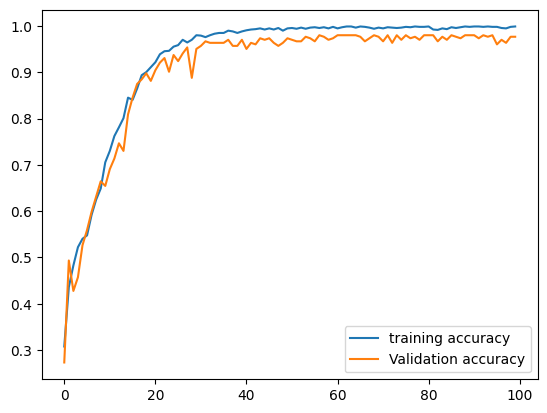

In [29]:
plt.plot(LRCN_model_history.history['categorical_accuracy'] , label = 'training accuracy')
plt.plot(LRCN_model_history.history['val_categorical_accuracy'] , label = 'Validation accuracy')
plt.legend(loc ='lower right')

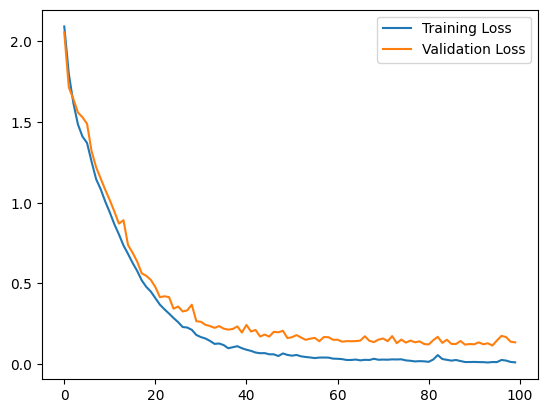

In [30]:
plt.plot(LRCN_model_history.history['loss'] , label = 'Training Loss')
plt.plot(LRCN_model_history.history['val_loss'] , label = 'Validation Loss')
plt.legend(loc = 'upper right')

In [31]:
LRCN_model.evaluate(X_test , y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_accuracy: 0.9820 - loss: 0.0232


[0.017506975680589676, 0.987500011920929]

#### Predicting Results

In [32]:
predictions = LRCN_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


In [33]:
results , actual = [] , []

for result in predictions:
  
  outcome = actions[np.argmax(result)]

  results.append(outcome)
  

for i in range(len(y_test)):

  act_out = actions[np.argmax(y_test[i])] 

  actual.append(act_out)


In [34]:
comparision_df = pd.DataFrame({'y_true' : actual , 'y_pred': results})

In [35]:
comparision_df

,y_true,y_pred
0,thankyou,thankyou
1,hello,hello
2,C,C
3,hello,hello
4,sorry,sorry
...,...,...
75,thankyou,thankyou
76,iloveyou,iloveyou
77,thankyou,thankyou
78,hello,hello


#### 4. Saving the Model

In [36]:
with open("LRCN_model" , 'wb') as file:
 pickle.dump(LRCN_model , file)

In [37]:
y_hat = predictions

In [38]:
y_hat.shape

(80, 10)

In [39]:
np.argmax(y_hat[0])

1

In [40]:
y_test

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

In [41]:
y_hat = np.argmax(y_hat , axis = 1).tolist()
y_true = np.argmax(y_test , axis = 1).tolist()

In [42]:
multilabel_confusion_matrix(y_true , y_hat)

array([[[59,  1],
        [ 0, 20]],

       [[64,  0],
        [ 0, 16]],

       [[64,  0],
        [ 1, 15]],

       [[72,  0],
        [ 0,  8]],

       [[76,  0],
        [ 0,  4]],

       [[78,  0],
        [ 0,  2]],

       [[75,  0],
        [ 0,  5]],

       [[79,  0],
        [ 0,  1]],

       [[76,  0],
        [ 0,  4]],

       [[76,  0],
        [ 0,  4]]], dtype=int64)

In [43]:
accuracy_score(y_true , y_hat)

0.9875